# Data Exploration

Now that the data has been collected, it's time to take a look around it to see what we have. To see my methods for collecting the data, look at `scrape_top_subreddits.py` and then `scrape_comments.py` in the `scripts` folder.

### Table of contents
- [The Data](#the-data)
- [Cleaning](#cleaning)
- [Data Processing](#data-processing)
- [Looking at Processed Data](#looking-at-processed-data)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import numpy as np
import seaborn as sns
sns.set_theme()

## The Data 

In [2]:
top_10 = pd.read_json("../private/comment_data_10.json")
top_100 = pd.read_json("../private/comment_data_100.json")
top_1000 = pd.read_json("../private/comment_data_1000.json")
top_2500 = pd.read_json("../private/comment_data_2500.json")

I split my dataset into four different sizes. The number in the file name is how far down the top subreddit list I went when scraping. So for example, `comment_data_10.json` contains every comment from the top ten posts of the past year from the top ten subreddits, while `comment_data_100.json` contains the same for the top 100 subredddits. `top_10` is the set I intend to use for basic experimentation, so I don't have to wait too long for operations to complete. Once I have my code worked out, I can scale it up to `top_100` for actual analysis. Then if that goes well and I want to scale up further, I can switch to `top_1000` or even `top_2500`.

In [3]:
top_10.head()

,subreddit,comment_id,text
0,funny,jg3d9yg,"""Oh my god! That's awful!"" Exactly how you wan..."
1,funny,jg3af9r,Her eyes when he stood up.
2,funny,jg3apmv,[deleted]
3,funny,jg3782t,the reporter's name is Brad Blanks
4,funny,jg39vhb,**Jennifer:** What are you getting in the way-...


Since I scraped the data myself, the format is already good for my purposes and I don't have to clean up much, other than removing the `[deleted]` and `[removed]` comments. Each file is structured like this, with the only difference being the number of rows. The `subreddit` column contains of the name the subreddit the comment was left on. The `comment_id` column contains an id which can be used with the reddit api to fetch more information about a comment, such as its number of upvotes, the post it was left on, or when it was made. Finally, the `text` column contains the text of the comment.

In [4]:
top_10.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9838 entries, 0 to 9837
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   subreddit   9838 non-null   object
 1   comment_id  9838 non-null   object
 2   text        9838 non-null   object
dtypes: object(3)
memory usage: 230.7+ KB


In [5]:
top_10.describe()

,subreddit,comment_id,text
count,9838,9838,9838
unique,10,9838,9456
top,aww,jg3d9yg,[deleted]
freq,1962,1,164


In [6]:
top_100.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120856 entries, 0 to 120855
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   subreddit   120856 non-null  object
 1   comment_id  120856 non-null  object
 2   text        120856 non-null  object
dtypes: object(3)
memory usage: 2.8+ MB


In [7]:
top_100.describe()

,subreddit,comment_id,text
count,120856,120856,120856
unique,100,120856,115028
top,cats,jg3d9yg,[deleted]
freq,2548,1,1342


In [8]:
top_1000.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1132141 entries, 0 to 1132140
Data columns (total 3 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   subreddit   1132141 non-null  object
 1   comment_id  1132141 non-null  object
 2   text        1132141 non-null  object
dtypes: object(3)
memory usage: 25.9+ MB


In [9]:
top_1000.describe()

,subreddit,comment_id,text
count,1132141,1132141,1132141
unique,1000,1132141,1056914
top,painting,jg3d9yg,[deleted]
freq,3851,1,9239


In [10]:
top_2500.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2320731 entries, 0 to 2320730
Data columns (total 3 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   subreddit   object
 1   comment_id  object
 2   text        object
dtypes: object(3)
memory usage: 53.1+ MB


In [11]:
top_2500.describe()

,subreddit,comment_id,text
count,2320731,2320731,2320731
unique,2492,2320731,2145538
top,Faces,jg3d9yg,[deleted]
freq,3858,1,17345


Almost all of this information seems to check out, and wow those big datasets have a lot of rows! But what are these 8 missing subreddits in the top_2500 dataset? We can pull in the list I used in my scraper to figures this out.

In [12]:
with open("../private/top_subreddits.txt") as f:
    expected = set(f.read().split())
actual = set(top_2500["subreddit"])
expected.difference(actual)

{'ForHire_GameDev',
 'ForHire_OG',
 'ForeverAloneDating',
 'GlamourSchool',
 'TheArtistStudio',
 'badtattoos',
 'recipegifs',
 'shortcircuit'}

Interesting, looking at these subreddits the problem for most of them seems to be that these subreddits haven't had any posts in the past year, and since I only looked at the top posts of the year, so there weren't any posts in the list.

## Cleaning

For now, lets focus on the top 100, since it's what i want to do my first actual work with, we can start be removing deleted and removed comments.

In [13]:
top_100 = top_100[top_100.text != "[deleted]"]
top_100 = top_100[top_100.text != "[removed]"].reset_index(drop=True)
top_100.shape

(118299, 3)

Down to 118,299 comments from 120,856 before, only around 2000 lost, pretty good! How many comments do I have per subreddit?

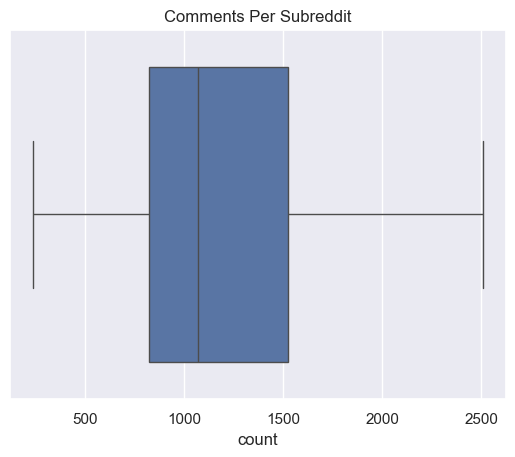

In [14]:
plot = sns.boxplot(top_100.subreddit.value_counts(), orient="h")
plot.set_title("Comments Per Subreddit")
plt.show()

Seems like a good number, although there are some with a lot less than others.

## Data Processing

Now I want to add some more statistics to this data, lets start with tokenizing the comments and counting the number of tokens.

In [15]:
top_100["tokens"] = top_100.text.map(nltk.word_tokenize)

In [16]:
top_100["num_tokens"] = top_100.tokens.map(len)
top_100.head()

,subreddit,comment_id,text,tokens,num_tokens
0,funny,jg3d9yg,"""Oh my god! That's awful!"" Exactly how you wan...","[``, Oh, my, god, !, That, 's, awful, !, '', E...",24
1,funny,jg3af9r,Her eyes when he stood up.,"[Her, eyes, when, he, stood, up, .]",7
2,funny,jg3782t,the reporter's name is Brad Blanks,"[the, reporter, 's, name, is, Brad, Blanks]",7
3,funny,jg39vhb,**Jennifer:** What are you getting in the way-...,"[*, *, Jennifer, :, *, *, What, are, you, gett...",19
4,funny,jg36sqa,They “were scared…of my brutish height.” 😂,"[They, “, were, scared…of, my, brutish, height...",9


In [17]:
top_100.num_tokens

0         24
1          7
2          7
3         19
4          9
          ..
118294     7
118295     2
118296    13
118297     7
118298     3
Name: num_tokens, Length: 118299, dtype: int64

All pretty short except a few extreme outliers, I wonder what those are?

In [18]:
top_100[top_100.num_tokens > 2000]

,subreddit,comment_id,text,tokens,num_tokens
41204,WritingPrompts,jbdwcd3,"""This is the UN PKF Big Stick Protocol approac...","[``, This, is, the, UN, PKF, Big, Stick, Proto...",2047
41296,WritingPrompts,jay1c1w,"""Look,"" said the demon. ""This is the 13th time...","[``, Look, ,, '', said, the, demon, ., ``, Thi...",2249
74778,EatCheapAndHealthy,kengegu,I also am limited to around $100 a month for g...,"[I, also, am, limited, to, around, $, 100, a, ...",2115


Seems to be on writing prompts, and one person writing about saving money on shopping. Next i'm going to add a few columns that should help with my analysis later.

In [19]:
top_100["num_types"] = top_100.tokens.map(lambda t: len(set(t)))
top_100["ttr"] = top_100["num_types"] / top_100["num_tokens"]
top_100["avg_word_len"] = top_100.tokens.map(lambda t: np.mean([len(tok) for tok in t]))
top_100.head()

,subreddit,comment_id,text,tokens,num_tokens,num_types,ttr,avg_word_len
0,funny,jg3d9yg,"""Oh my god! That's awful!"" Exactly how you wan...","[``, Oh, my, god, !, That, 's, awful, !, '', E...",24,22,0.916667,3.250000
1,funny,jg3af9r,Her eyes when he stood up.,"[Her, eyes, when, he, stood, up, .]",7,7,1.000000,3.000000
2,funny,jg3782t,the reporter's name is Brad Blanks,"[the, reporter, 's, name, is, Brad, Blanks]",7,7,1.000000,4.142857
3,funny,jg39vhb,**Jennifer:** What are you getting in the way-...,"[*, *, Jennifer, :, *, *, What, are, you, gett...",19,16,0.842105,2.526316
4,funny,jg36sqa,They “were scared…of my brutish height.” 😂,"[They, “, were, scared…of, my, brutish, height...",9,9,1.000000,4.000000


In [20]:
top_100.describe()

,num_tokens,num_types,ttr,avg_word_len
count,118299.000000,118299.000000,118299.000000,118299.000000
mean,27.472185,21.117161,0.913297,3.977055
std,57.617757,28.901683,0.113921,3.219697
min,1.000000,1.000000,0.016667,1.000000
25%,7.000000,7.000000,0.857143,3.350000
50%,14.000000,13.000000,0.954545,3.750000
75%,28.000000,24.000000,1.000000,4.200000
max,2249.000000,768.000000,1.000000,765.000000


In [21]:
top_100.to_pickle("../private/top_100_processed.pkl")

Now I'll quickly process the two bigger datasets for later use.

In [22]:
top_1000 = top_1000[top_1000.text != "[deleted]"]
top_1000 = top_1000[top_1000.text != "[removed]"].reset_index(drop=True)
top_1000["tokens"] = top_1000.text.map(nltk.word_tokenize)
top_1000["num_tokens"] = top_1000.tokens.map(len)
top_1000["num_types"] = top_1000.tokens.map(lambda t: len(set(t)))
top_1000["ttr"] = top_1000["num_types"] / top_1000["num_tokens"]
top_1000["avg_word_len"] = top_1000.tokens.map(lambda t: np.mean([len(tok) for tok in t]))
top_1000.to_pickle("../private/top_1000_processed.pkl")

c:\Users\oci\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\oci\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [23]:
top_2500 = top_2500[top_2500.text != "[deleted]"]
top_2500 = top_2500[top_2500.text != "[removed]"].reset_index(drop=True)
top_2500["tokens"] = top_2500.text.map(nltk.word_tokenize)
top_2500["num_tokens"] = top_2500.tokens.map(len)
top_2500["num_types"] = top_2500.tokens.map(lambda t: len(set(t)))
top_2500["ttr"] = top_2500["num_types"] / top_2500["num_tokens"]
top_2500["avg_word_len"] = top_2500.tokens.map(lambda t: np.mean([len(tok) for tok in t]))
top_2500.to_pickle("../private/top_2500_processed.pkl")

c:\Users\oci\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\oci\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


## Looking at Processed Data

Finally, lets take a quick look around some of the newly created statistics. Number of tokens for example!

Text(0.5, 1.0, 'Number of Tokens, Top 100 Subreddits')

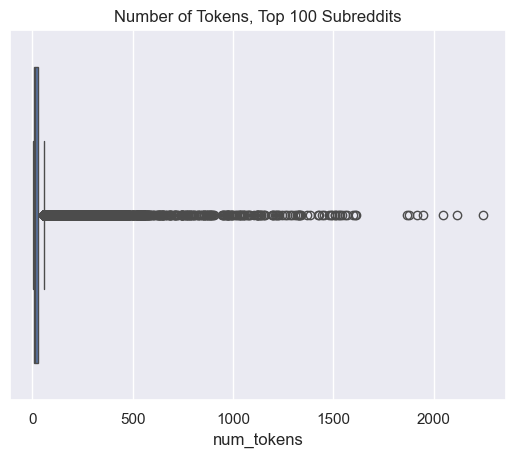

In [24]:
sns.boxplot(x=top_100["num_tokens"]).set_title("Number of Tokens, Top 100 Subreddits")

That is a lot of outliers, I wonder what it looks like without those...

Text(0.5, 1.0, 'Number of Tokens, No Outliers, Top 100 Subreddits')

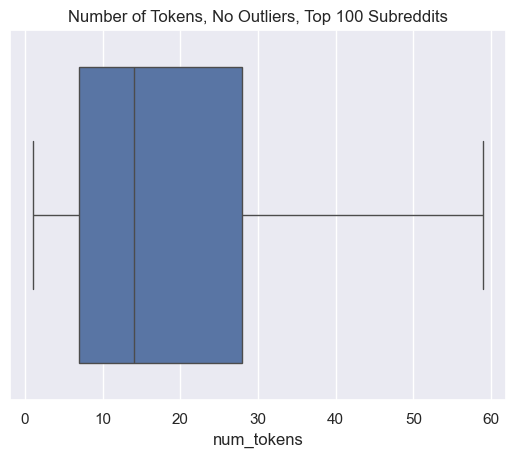

In [25]:
sns.boxplot(x=top_100["num_tokens"], showfliers=False).set_title("Number of Tokens, No Outliers, Top 100 Subreddits")

All very short, what about the top 2500?

Text(0.5, 1.0, 'Number of Tokens, Top 2500 Subreddits')

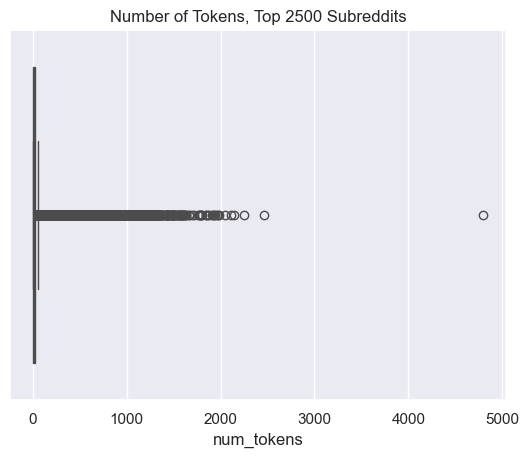

In [26]:
sns.boxplot(x=top_2500["num_tokens"]).set_title("Number of Tokens, Top 2500 Subreddits")

Wow one person really likes typing, i wonder what that comment is?

In [27]:
top_2500[top_2500.num_tokens > 4000]

,subreddit,comment_id,text,tokens,num_tokens,num_types,ttr,avg_word_len
321487,math,kffufp8,2^3 + 3^3 + 4^3 + 5^3 + 6^3 + 7^3 + 8^3 + 9^3 ...,"[2^3, +, 3^3, +, 4^3, +, 5^3, +, 6^3, +, 7^3, ...",4798,103,0.021467,2.048979


In [28]:
print(list(top_2500[top_2500.num_tokens > 4000].text)[0])

2^3 + 3^3 + 4^3 + 5^3 + 6^3 + 7^3 + 8^3 + 9^3 = 2^10 + 10^3

10^3 - 9^3 - 8^3 - 7^3 - 6^3 - 5^3 - 4^3 - 3^3 - 2^3 = -2^10

---

This text is in protest against reddit forcing its new user interface on mobile users regardless of whether they're opted out or not. They know it sucks and know users hate it and now they're forcing it on those users. If reddit wants to play silly games then so can us users. Each comment can be upto 10,000 characters in length and data costs money to store and serve. So, this is me doing my bit making reddit pay for its action. If we all adopt this measure, costs may start to add up for them. This signature uses "-" to pad out the comment to 10,000 chars which show up as a horizontal line.

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Oh, a user protesting a UI change by making all of their comments extremely long. fascinating.

Text(0.5, 1.0, 'Number of Tokens, No Outliers, Top 2500 Subreddits')

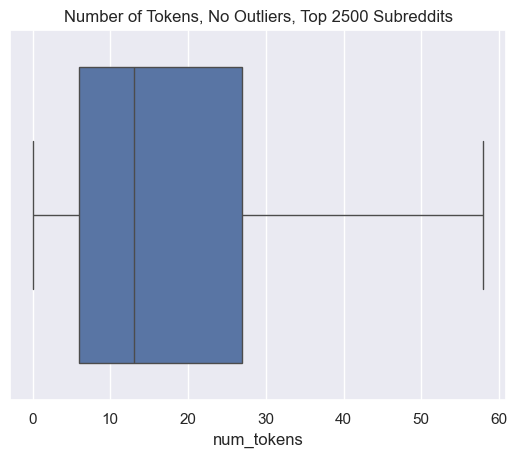

In [29]:
sns.boxplot(x=top_2500["num_tokens"], showfliers=False).set_title("Number of Tokens, No Outliers, Top 2500 Subreddits")

And this looks about the same.